In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_excel('sample_data.xlsx')
print(df)

    Week Start     Bookings
0   2021-08-01   129.808103
1   2021-08-08   122.962071
2   2021-08-15   153.664518
3   2021-08-22   234.772937
4   2021-08-29   214.594944
..         ...          ...
99  2023-06-25   598.200447
100 2023-07-02   269.178765
101 2023-07-09   333.417922
102 2023-07-16   551.074481
103 2023-07-23  1782.905032

[104 rows x 2 columns]


In [24]:
df.set_index('Week Start',inplace=True)
df.head()

,Bookings
Week Start,
2021-08-01,129.808103
2021-08-08,122.962071
2021-08-15,153.664518
2021-08-22,234.772937
2021-08-29,214.594944


In [25]:
df.describe()

,Bookings
count,104.000000
mean,298.630160
std,270.466468
min,79.037187
25%,168.917520
50%,214.398070
75%,300.018497
max,1782.905032


<Axes: xlabel='Week Start'>

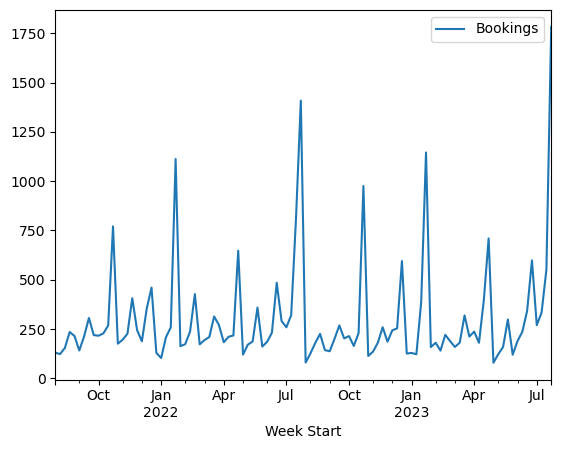

In [32]:
df.plot()
#To check whether data has seasonal trends or not. If seasonal trend is found, then use SARIMA model


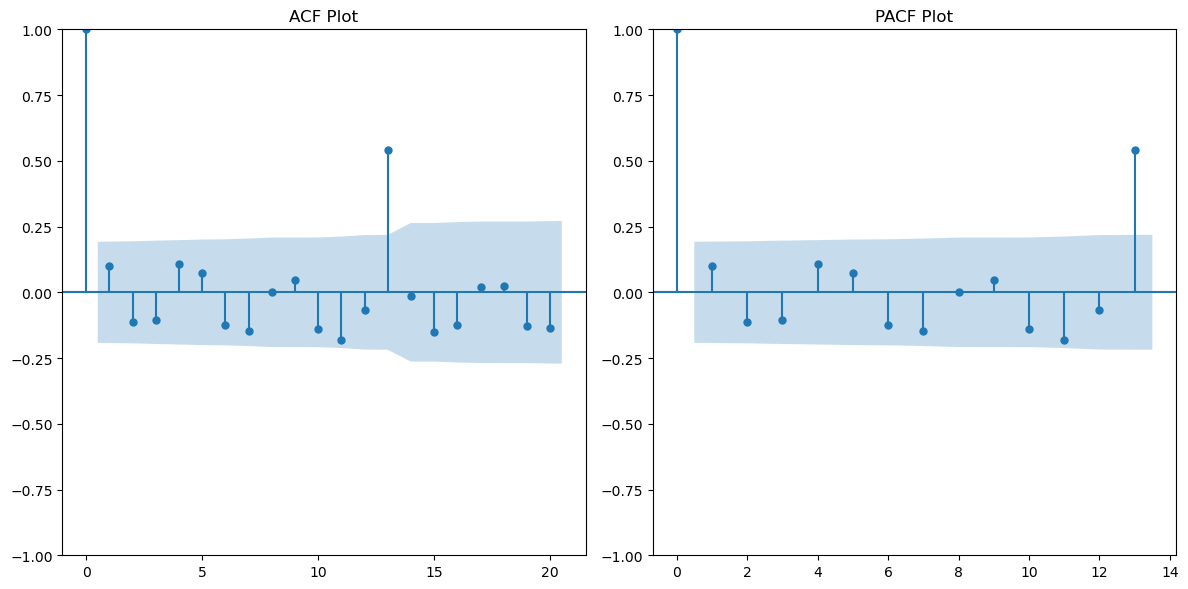

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ACF plot- Autocorrelation function to get the p value i.e. Max value after which it diminishes (has to be integer)
plt.figure(figsize =(12,6))
plt.subplot(1,2,1)# grid size
plot_acf(df,lags=20, ax=plt.gca()) #display auto correlation values for the first 20 lags 
plt.title('ACF Plot')

#PACF plot-Partial Autocorrelation to get the p value i.e. Max value after which it diminishes (has to be integer)
plt.subplot(1,2,2)# grid size
plot_acf(df,lags=13, ax=plt.gca()) #display auto correlation values for the first 13 lags 
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [ ]:
#Auto correlation function(ACF) helps to get the AR model value i.e p value. 
#ACF measures and plots avg correlation b/w data points in timeseries at diff lags

In [31]:
# To use SARIMA model, first we need to make the data stationary i.e. to remove the seasonal trends 
# and make it non-seasonal or stationary. ADH test is performed

from statsmodels.tsa.stattools import adfuller
#CI is 95% and alpha is 5%. Assuming out of 100 times, 95 times data will be found Stationary
#Null Hypo: It is non stationary
#Alternate Hypo: It is stationary

def adfuller_test(Bookings):
    result=adfuller(Bookings)
    labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value, label in zip(result,labels):
        print(label+':'+str(value))
    if result[1] <=.05:
        print("Strong evidence against null hypo")
    else:
        print("Weak evidence against null hypo")
        
adfuller_test(df['Bookings'])

ADF Test Statistic:-2.029835274093249
p-value:0.27364649177938016
#Lags Used:13
Number of Observations Used:90
Weak evidence against null hypo


In [34]:
#### If it is non stationary we have to make it Stationary
### Differencing
df['Seasonal First Difference']=df['Bookings']-df['Bookings'].shift(13)
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic:-5.60927274215038
p-value:1.2139647354157933e-06
#Lags Used:12
Number of Observations Used:78
Strong evidence against null hypo


In [49]:
### For non-seasonal data
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Bookings'],order=(1,1,1),seasonal_order=(1,1,1,13)) #training model with hist data
results=model.fit()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99821D+00    |proj g|=  6.41228D-01

At iterate    5    f=  5.64814D+00    |proj g|=  4.25043D-03

At iterate   10    f=  5.64587D+00    |proj g|=  6.57312D-03

At iterate   15    f=  5.62190D+00    |proj g|=  4.51918D-02

At iterate   20    f=  5.53653D+00    |proj g|=  4.27272D-03

At iterate   25    f=  5.53347D+00    |proj g|=  1.81548D-02

At iterate   30    f=  5.53277D+00    |proj g|=  1.35290D-04

At iterate   35    f=  5.53127D+00    |proj g|=  2.95891D-02

At iterate   40    f=  5.52682D+00    |proj g|=  8.87588D-03

At iterate   45    f=  5.52641D+00    |proj g|=  1.64792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<Axes: xlabel='Week Start'>

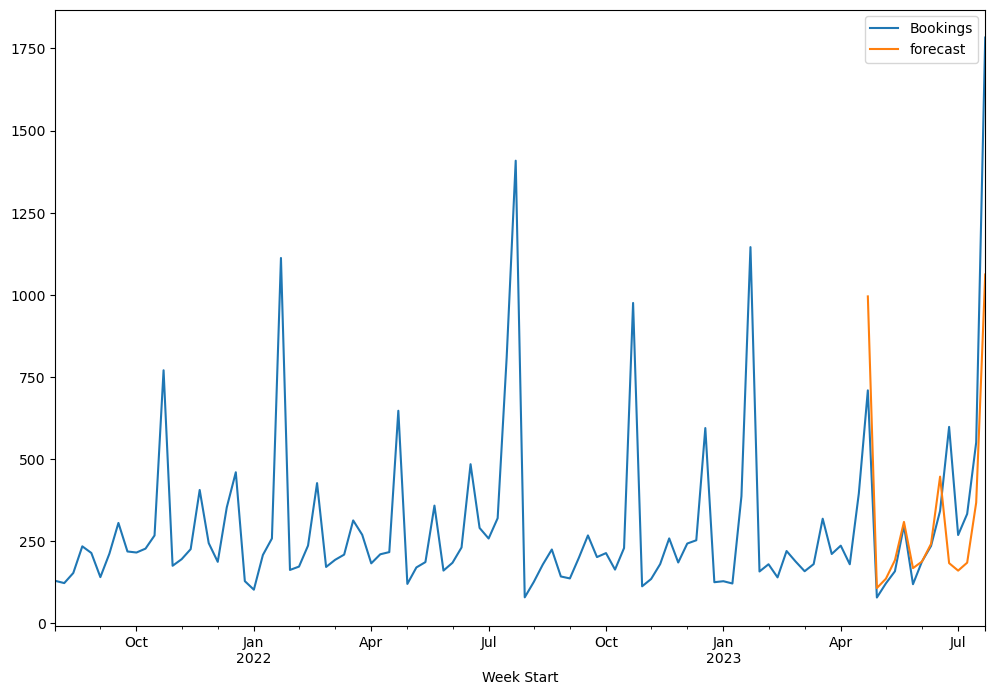

In [50]:
df['forecast']=results.predict(start=90, end = 104, dynamic=True)
df[['Bookings','forecast']].plot(figsize=(12,8))

In [47]:
### Predicting future forecast
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+DateOffset(weeks=x)for x in range(0,24)]
future_dataset_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_dataset_df.index.name = 'Week Start'
future_dataset_df.head()

,Bookings,Seasonal First Difference,forecast
Week Start,,,
2023-07-30,NaN,NaN,NaN
2023-08-06,NaN,NaN,NaN
2023-08-13,NaN,NaN,NaN
2023-08-20,NaN,NaN,NaN
2023-08-27,NaN,NaN,NaN


/var/folders/qg/9qnm2g51701gxcxzzwr1q97c0000gn/T/ipykernel_72847/1378748635.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df,future_dataset_df])


<Axes: xlabel='Week Start'>

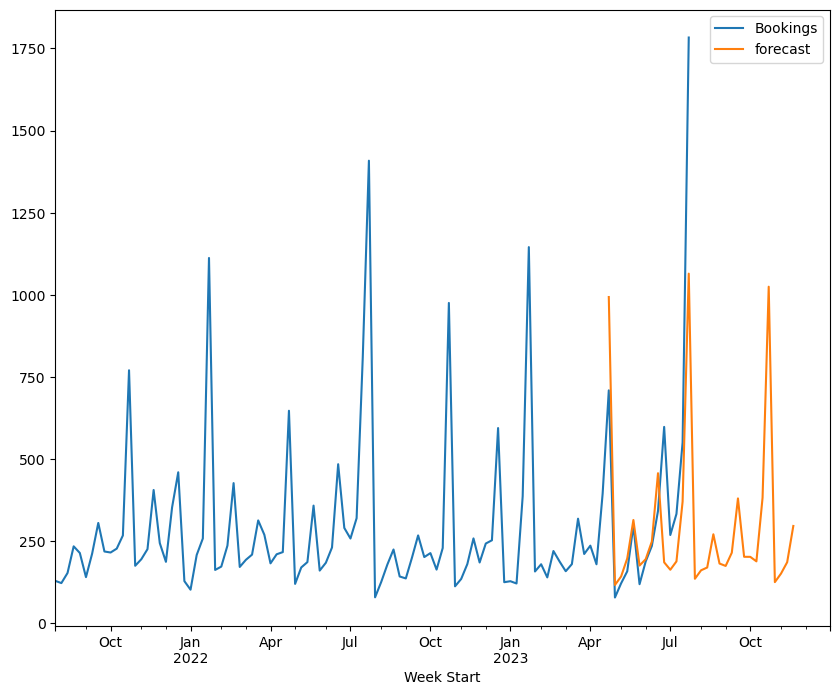

In [45]:
future_df=pd.concat([df,future_dataset_df])
future_df['forecast']=results.predict(start=90, end=120, dynamic=True)
future_df[['Bookings','forecast']].plot(figsize=(10,8))